# 8Day subsampling on the OceanColor Dataset

In [17]:
# now do the subsampling of oceancolor dataset for 3d, smoother finite difference?

In [18]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

# load oceancolor dataset

In [19]:
ds_8day = xr.open_mfdataset('./data_collector/Seawifs_Arabian_Sea_chl_ocx_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector/Seawifs_Arabian_Sea_chl_ocx_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

In [20]:
# how much data is contained here? let's get the answer in MB
print([(ds.nbytes / 1e6) for ds in both_datasets])

[479.024296, 3803.307096]


In [21]:
# load all the data in the memory
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 598)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
 Data variables:
     chl_ocx        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 4748)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

In [22]:
# fix bad data
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chl_ocx.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chl_ocx[n].values 
        ds.chl_ocx.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [23]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [24]:
ds_8day.chl_ocx>0  # mask

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chl_ocx' (time: 598, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ...,  Tr

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


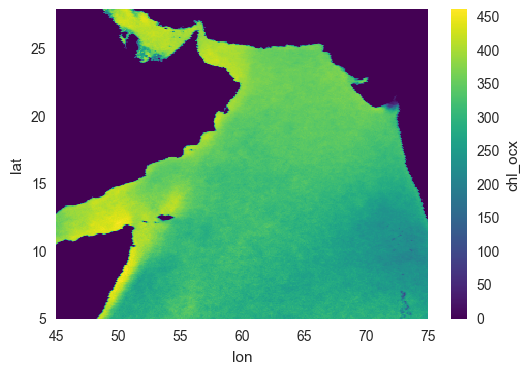

In [25]:
# count the number of ocean data points
(ds_8day.chl_ocx>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


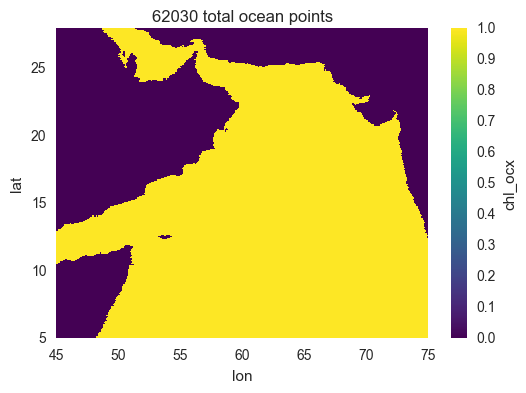

In [26]:
#  find a mask for the land
ocean_mask = (ds_8day.chl_ocx>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chl_ocx>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [27]:
ds_8day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 598)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
Data variables:
    chl_ocx        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

In [28]:
ds_daily

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 4748)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 1998-01-03 ...
Data variables:
    chl_ocx        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


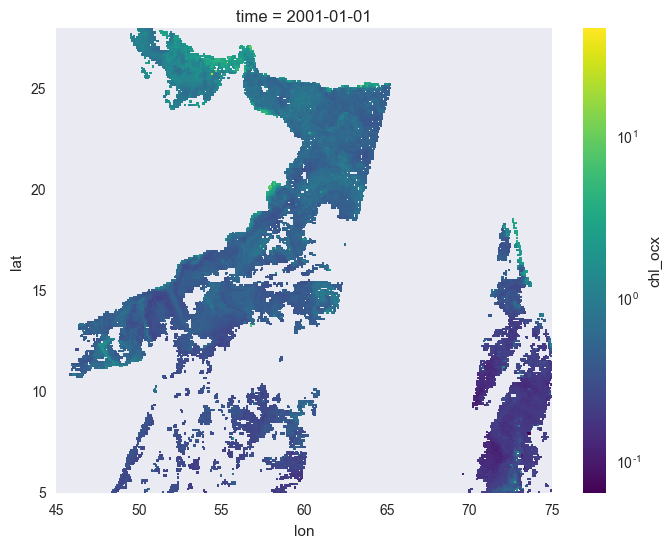

In [29]:
plt.figure(figsize=(8,6))
ds_daily.chl_ocx.sel(time='2001-01-01',method='nearest').plot(norm=LogNorm())
#ds_daily.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [30]:
list(ds_daily.groupby('time')) # take a look at what's inside

[(numpy.datetime64('1998-01-01T00:00:00.000000000'), <xarray.Dataset>
  Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3)
  Coordinates:
    * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
    * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
    * rgb            (rgb) int64 0 1 2
    * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
      time           datetime64[ns] 1998-01-01
  Data variables:
      chl_ocx        (lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
      palette        (rgb, eightbitcolor) float64 -109.0 0.0 108.0 -112.0 0.0 ...),
 (numpy.datetime64('1998-01-02T00:00:00.000000000'), <xarray.Dataset>
  Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3)
  Coordinates:
    * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
    * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
    * rgb       

In [31]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 4748)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 1998-01-03 ...
Data variables:
    chl_ocx  (time) int64 9334 7420 13220 12035 10712 11513 15020 9862 11994 ...
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...

In [32]:
ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chl_ocx' (time: 4748)>
array([ 0.15047558,  0.11961954,  0.21312268, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 1998-01-03 ...

In [33]:
#count_8day, count_2day, count_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in (ds_8day, ds_2day, ds_daily)]
count_8day,count_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day, ds_daily)]

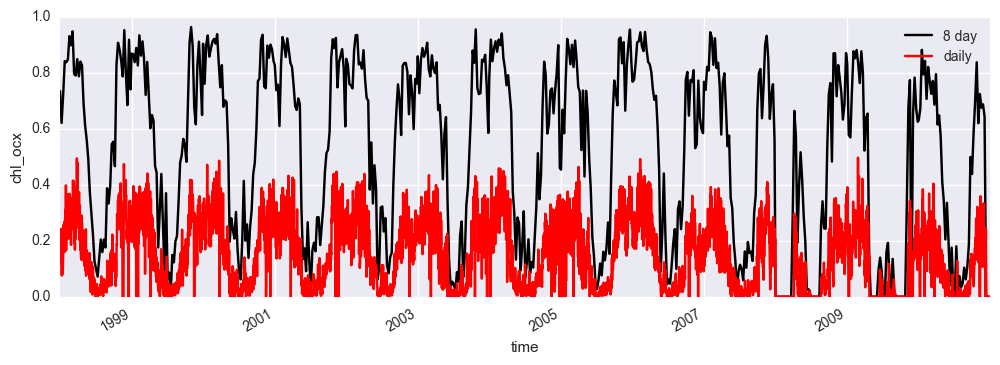

In [34]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')
#count_2day.plot(color='b')

#plt.legend(['8 day','daily',  '2 day' ])
plt.legend(['8 day','daily'])

In [35]:
# Seasonal Climatology
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

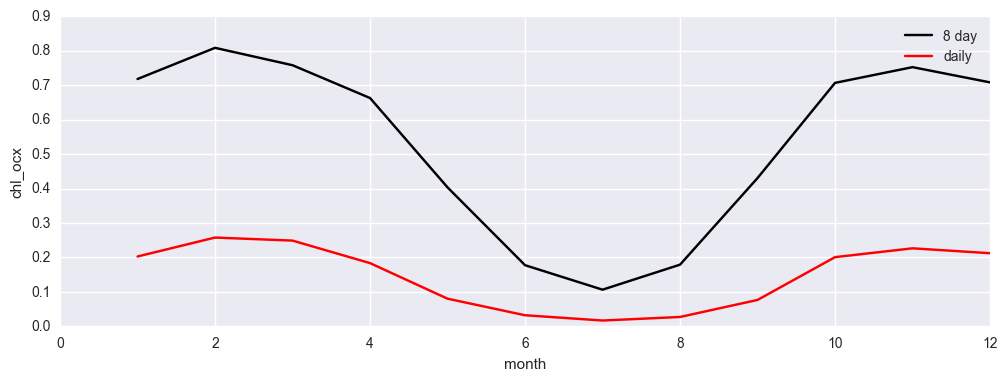

In [36]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


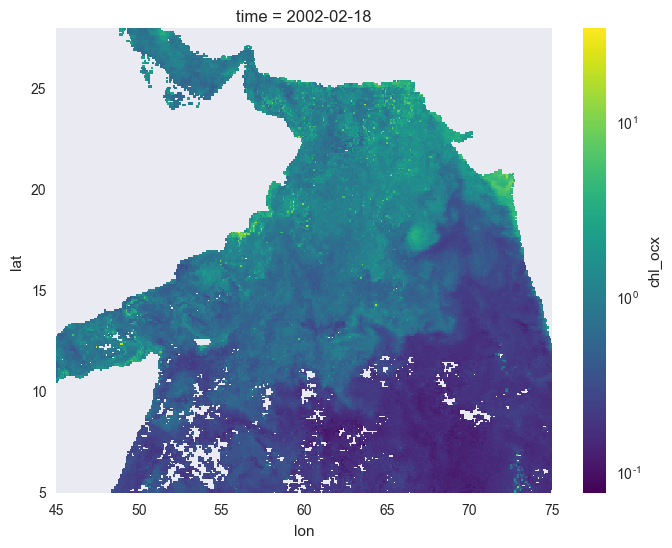

In [37]:
# Maps of individual days
target_date = '2002-02-15'
plt.figure(figsize=(8,6))
ds_8day.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


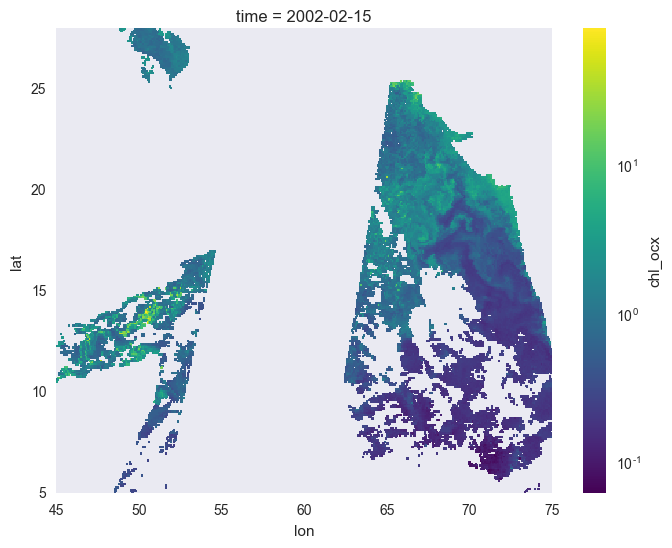

In [38]:
plt.figure(figsize=(8,6))
ds_daily.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [39]:
ds_daily.chl_ocx[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chl_ocx' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 1998-01-01
    lon      (points) float64 65.04 70.04
    lat      (points) float64 16.04 18.04
  * points   (points) int64 0 1

In [40]:
ds_daily.chl_ocx.sel_points?

In [41]:
ds_8day = ds_daily.resample('8D', dim='time')
ds_8day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 594)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
Data variables:
    chl_ocx        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


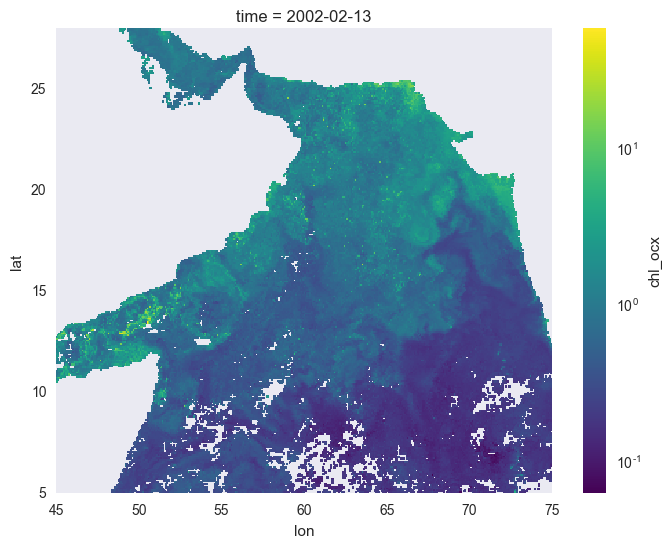

In [42]:
plt.figure(figsize=(8,6))
ds_8day.chl_ocx.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [43]:
# check the range for the longitude
print(ds_8day.lon.min(),'\n' ,ds_8day.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# One GDP Floater
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [44]:
# in the following we deal with the data from the gdp float
from buyodata  import buoydata
import os

In [45]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']
#fnames = ['./gdp_float/buoydata_1_5000.dat']

In [46]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='1998-01-01' # we only have data after this data for cho_ocx
dfvvAll = dfAll[dfAll.time>='1998-01-01']

sum(dfvvAll.time<'1998-01-01') # recheck whether the time is 

0

In [47]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


id           lat           lon          temp            ve  \
count  2.557953e+07  2.538314e+07  2.538314e+07  2.360937e+07  2.534938e+07   
mean   2.438031e+06 -1.745947e+00  2.130167e+02  2.012396e+01 -8.832363e-02   
std    8.994174e+06  3.342499e+01  9.709989e+01  8.165937e+00  2.496411e+01   
min    1.831000e+03 -7.764700e+01  0.000000e+00 -1.685000e+01 -2.916220e+02   
25%    4.484500e+04 -3.085600e+01  1.507250e+02  1.494600e+01 -1.407100e+01   
50%    7.220200e+04 -3.815000e+00  2.169080e+02  2.236300e+01 -8.330000e-01   
75%    1.183960e+05  2.719900e+01  3.056560e+02  2.694900e+01  1.289400e+01   
max    6.399288e+07  8.989900e+01  3.600000e+02  4.595000e+01  4.417070e+02   

                 vn           spd       var_lat       var_lon       var_tmp  
count  2.534938e+07  2.534938e+07  2.557953e+07  2.557953e+07  2.557953e+07  
mean   4.268638e-01  2.572171e+01  7.677663e+00  7.678056e+00  7.702520e+01  
std    2.025773e+01  1.929160e+01  8.728392e+01  8.728389e+01  2.666235e+02  
min   -2.601400e+02  0.000000e+00  5.268300e-07 -3.941600e-02  1.001300e-03  
25%   -1.028900e+01  1.258400e+01  4.855300e-06  8.181100e-06  1.498800e-03  
50%    1.500000e-01  2.129100e+01  1.032600e-05  1.783300e-05  1.789900e-03  
75%    1.084200e+01  3.351500e+01  2.719100e-05  5.085400e-05  3.174000e-03  
max    2.783220e+02  4.421750e+02  1.000000e+03  1.000000e+03  1.000000e+03

dfvvAll.shape is (25579526, 11), floatsAll.shape is (139856, 11)


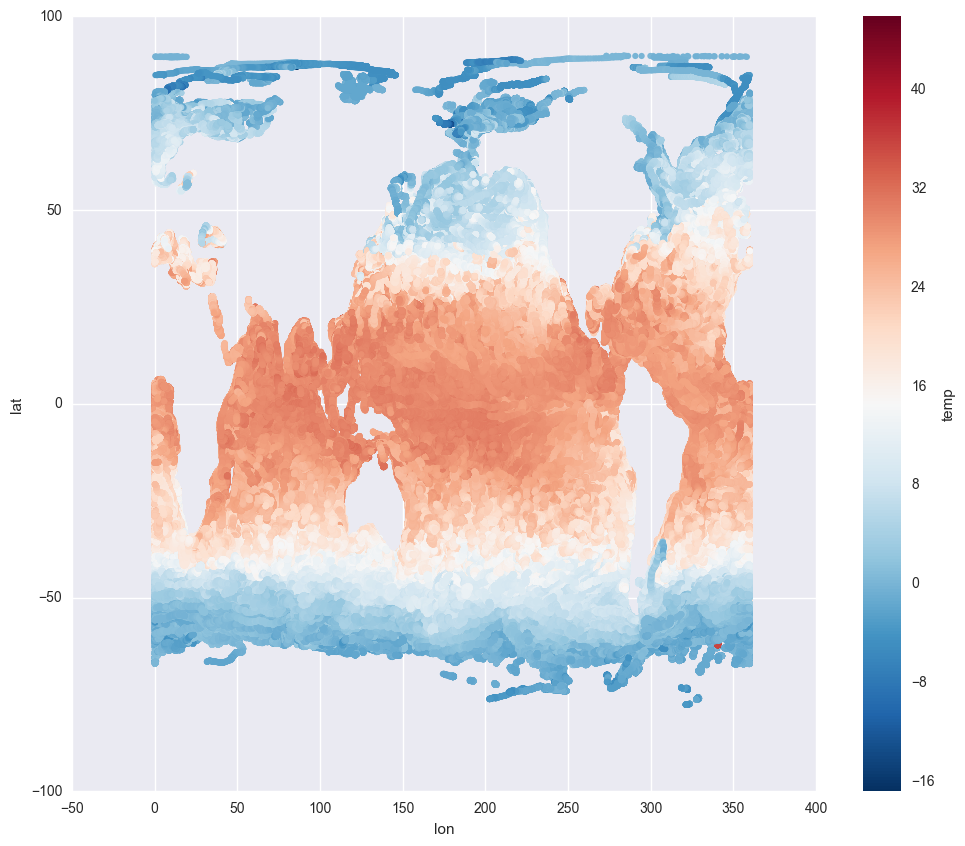

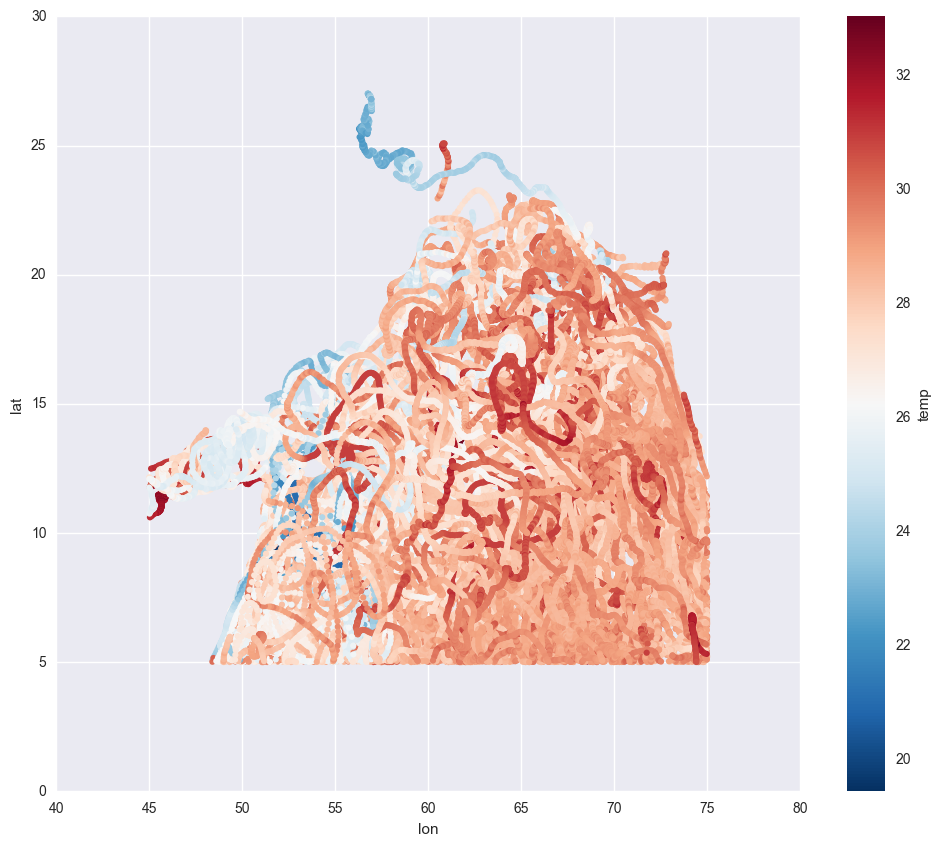

In [48]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [49]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 299, time: 22982)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-01-01T06:00:00 ...
  * id       (id) int64 7574 9081 10206 10207 10208 11089 12676 12701 12737 ...
Data variables:
    lat      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    lon      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    temp     (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    ve       (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    vn       (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    spd      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_lat  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_lon  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_tmp  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...

In [50]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_8D =floatsDSAll.resample('8D', dim='time')
floatsDSAll_8D

<xarray.Dataset>
Dimensions:  (id: 299, time: 845)
Coordinates:
  * id       (id) int64 7574 9081 10206 10207 10208 11089 12676 12701 12737 ...
  * time     (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
Data variables:
    vn       (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    temp     (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    spd      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_tmp  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    ve       (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    lon      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_lon  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    var_lat  (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    lat      (time, id) float64 nan nan nan nan nan nan nan nan nan nan nan ...

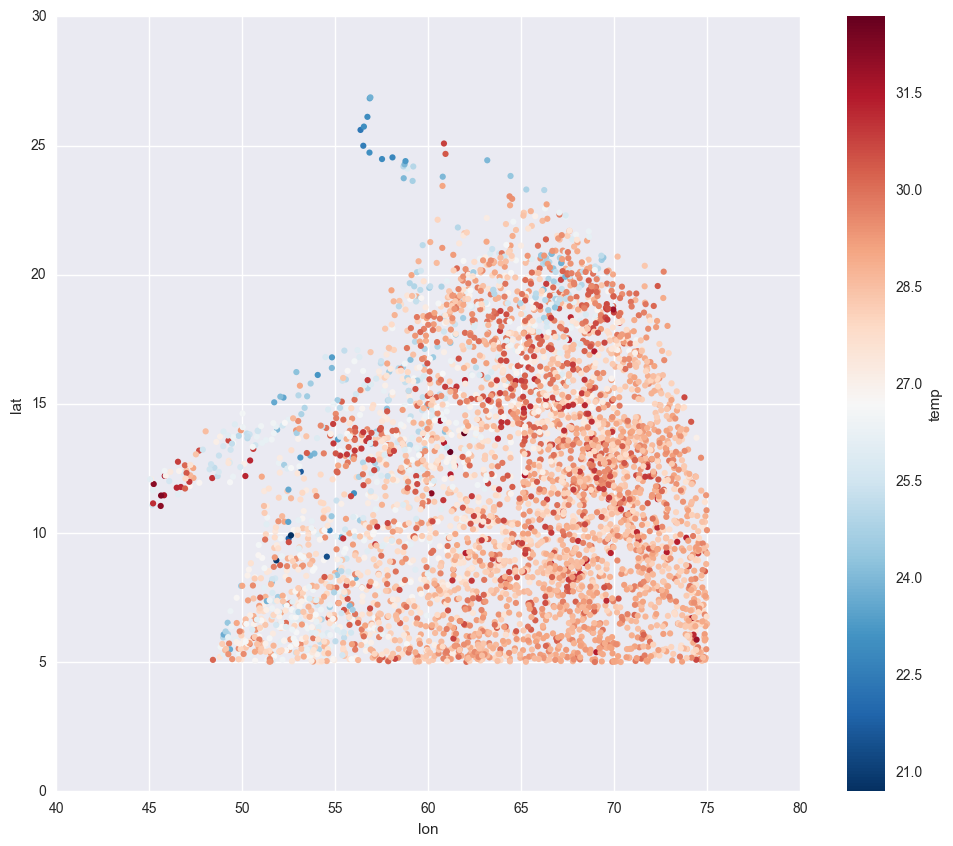

In [51]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_8D = floatsDSAll_8D.to_dataframe()
floatsDFAll_8D
floatsDFAll_8D = floatsDFAll_8D.reset_index()
floatsDFAll_8D
# visualize the 2D-floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_8D.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [52]:
# get the value for the chllorophy for each data entry
floatsDFAll_8Dtimeorder = floatsDFAll_8D.sort_values(['time','id'],ascending=True)
floatsDFAll_8Dtimeorder # check whether it is time ordered!!
# should we drop nan to speed up??

id       time  vn  temp  spd  var_tmp  ve  lon  var_lon  \
0           7574 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
845         9081 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
1690       10206 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
2535       10207 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
3380       10208 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
4225       11089 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
5070       12676 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
5915       12701 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
6760       12737 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
7605       12739 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
8450       12741 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
9295       13557 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
10140      13558 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
10985      13583 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
11830      15703 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
12675      15706 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
13520      15707 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
14365      18869 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
15210      18871 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
16055      20321 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
16900      20326 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
17745      20371 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
18590      25002 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
19435      25006 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
20280      26403 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
21125      27054 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
21970      27068 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
22815      27069 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
23660      27139 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
24505      28841 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
...          ...        ...  ..   ...  ...      ...  ..  ...      ...   
228149   9918868 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
228994  60073460 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
229839  60074440 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
230684  60077450 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
231529  60150420 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
232374  60454500 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
233219  60656200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
234064  60657200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
234909  60658190 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
235754  60659110 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
236599  60659120 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
237444  60659190 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
238289  60659200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
239134  60940960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
239979  60940970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
240824  60941960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
241669  60941970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
242514  60942960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
243359  60942970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
244204  60943960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
245049  60943970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
245894  60944960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
246739  60944970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   

In [53]:
floatsDFAll_8Dtimeorder.lon.dropna().shape  

(4803,)

In [54]:
mask = floatsDFAll_8Dtimeorder.lon.isnull() | floatsDFAll_8Dtimeorder.lat.isnull() | floatsDFAll_8Dtimeorder.time.isnull()
mask
floatsDFAll_8Dtimeorder[~mask].shape # the {long, lat, time} data has lots of values (4803,) 

(4803, 11)

In [55]:
# this one line avoid the list above
tmpAll = ds_8day.chl_ocx.sel_points(time=list(floatsDFAll_8Dtimeorder.time),lon=list(floatsDFAll_8Dtimeorder.lon), lat=list(floatsDFAll_8Dtimeorder.lat), method='nearest')
print('the count of nan vaues in tmpAll is',tmpAll.to_series().isnull().sum())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |


the count of nan vaues in tmpAll is 251252


In [56]:
#print(tmpAll.dropna().shape)
tmpAll.to_series().dropna().shape  # (1403,) good values

(1403,)

after editing the dataframe the nan values in 'chl_ocx' is 251252


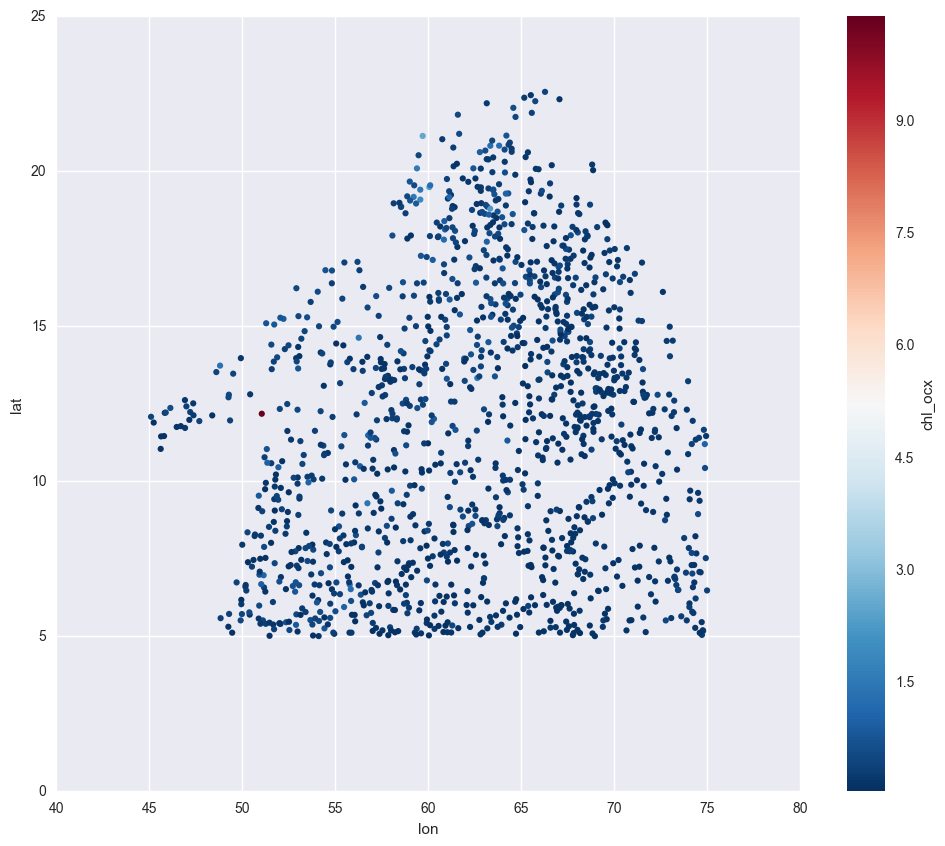

In [57]:
# tmp.to_series() to transfer it from xarray dataset to series
floatsDFAll_8Dtimeorder['chl_ocx'] = pd.Series(np.array(tmpAll.to_series()), index=floatsDFAll_8Dtimeorder.index)
print("after editing the dataframe the nan values in 'chl_ocx' is",floatsDFAll_8Dtimeorder.chl_ocx.isnull().sum() )  # they should be the same values as above

# take a look at the data
floatsDFAll_8Dtimeorder

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_8Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_ocx', cmap='RdBu_r', edgecolor='none', ax=ax)

In [58]:
def scale(x):
    logged = np.log10(x)
    return logged

(1403,)

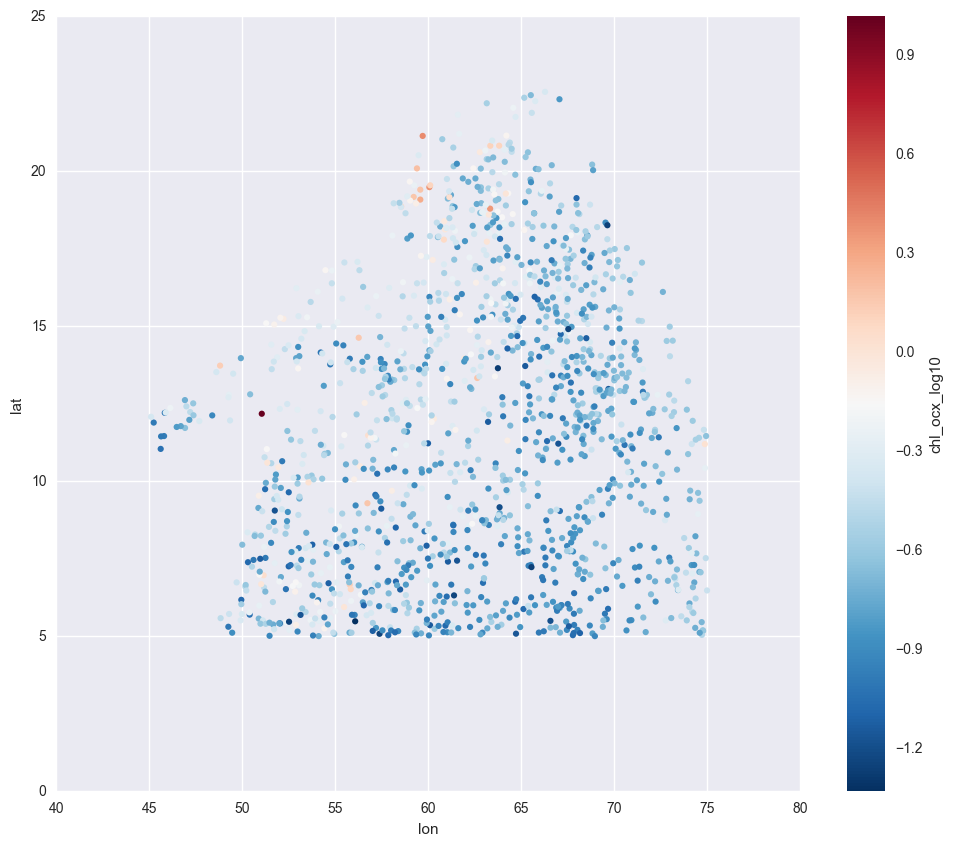

In [59]:
#print(floatsAll_timeorder['chl_ocx'].apply(scale))
floatsDFAll_8Dtimeorder['chl_ocx_log10'] = floatsDFAll_8Dtimeorder['chl_ocx'].apply(scale)
floatsDFAll_8Dtimeorder
#print("after the transformation the nan values in 'chl_ocx_log10' is", floatsAll_timeorder.chl_ocx_log10.isnull().sum() )

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_8Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_ocx_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAll_8Dtimeorder.chl_ocx_log10.dropna().shape  # (1403,) -- not too much data, but it is ok

In [60]:
# take the diff of the chl_ocx, and this has to be done in xarray
# transfer the dataframe into xarry dataset again
# take the difference
floatsDFAll_8Dtimeorder

id       time  vn  temp  spd  var_tmp  ve  lon  var_lon  \
0           7574 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
845         9081 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
1690       10206 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
2535       10207 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
3380       10208 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
4225       11089 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
5070       12676 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
5915       12701 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
6760       12737 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
7605       12739 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
8450       12741 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
9295       13557 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
10140      13558 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
10985      13583 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
11830      15703 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
12675      15706 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
13520      15707 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
14365      18869 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
15210      18871 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
16055      20321 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
16900      20326 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
17745      20371 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
18590      25002 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
19435      25006 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
20280      26403 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
21125      27054 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
21970      27068 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
22815      27069 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
23660      27139 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
24505      28841 1998-01-01 NaN   NaN  NaN      NaN NaN  NaN      NaN   
...          ...        ...  ..   ...  ...      ...  ..  ...      ...   
228149   9918868 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
228994  60073460 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
229839  60074440 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
230684  60077450 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
231529  60150420 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
232374  60454500 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
233219  60656200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
234064  60657200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
234909  60658190 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
235754  60659110 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
236599  60659120 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
237444  60659190 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
238289  60659200 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
239134  60940960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
239979  60940970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
240824  60941960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
241669  60941970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
242514  60942960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
243359  60942970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
244204  60943960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
245049  60943970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
245894  60944960 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   
246739  60944970 2016-06-27 NaN   NaN  NaN      NaN NaN  NaN      NaN   

In [ ]:
# unstack() will provide a 2d dataframe
# reset_index() will reset all the index as columns

check the sum of the chl_ocx before the merge -17.709660548468428
check the sum of the chl_ocx after the merge -17.709660548468428


(338,)

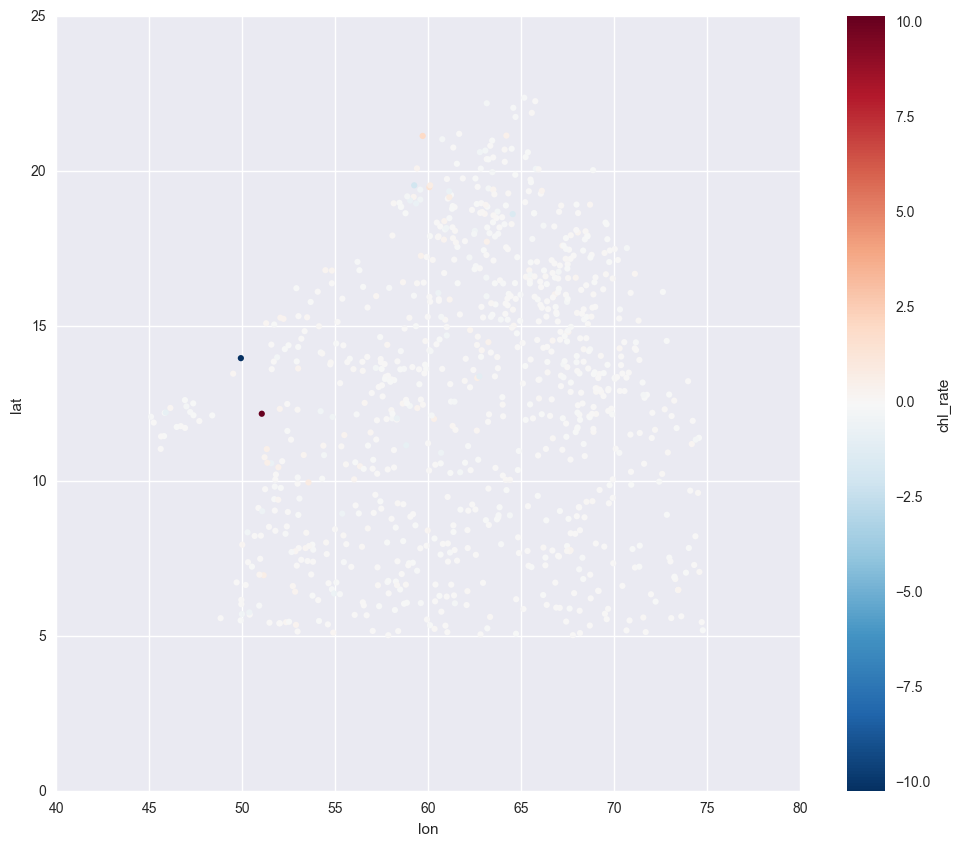

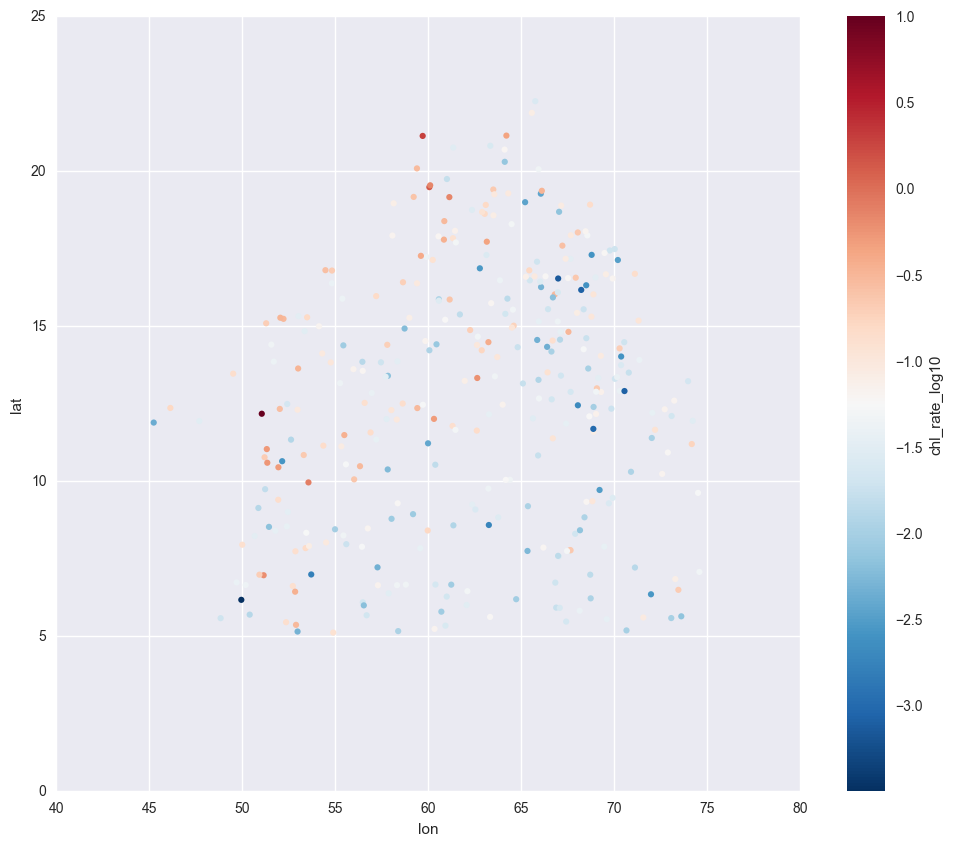

In [61]:
# prepare the data in dataset and about to take the diff
tmp = xr.Dataset.from_dataframe(floatsDFAll_8Dtimeorder.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
# take the diff on the chl_ocx
chl_ocx_rate = tmp.diff(dim='time',n=1).chl_ocx.to_series().reset_index()
# make the column to a proper name
chl_ocx_rate.rename(columns={'chl_ocx':'chl_rate'}, inplace='True')
chl_ocx_rate


# merge the two dataframes {floatsDFAll_2Dtimeorder; chl_ocx_rate} into one dataframe based on the index {id, time} and use the left method
floatsDFAllRate_8Dtimeorder=pd.merge(floatsDFAll_8Dtimeorder,chl_ocx_rate, on=['time','id'], how = 'left')
floatsDFAllRate_8Dtimeorder

# check 
print('check the sum of the chl_ocx before the merge', chl_ocx_rate.chl_rate.sum())
print('check the sum of the chl_ocx after the merge',floatsDFAllRate_8Dtimeorder.chl_rate.sum())


# visualize the chlorophyll rate, it is *better* to visualize at this scale
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_8Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the chlorophyll rate on the log scale
floatsDFAllRate_8Dtimeorder['chl_rate_log10'] = floatsDFAllRate_8Dtimeorder['chl_rate'].apply(scale)
floatsDFAllRate_8Dtimeorder
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_8Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAllRate_8Dtimeorder.chl_rate_log10.dropna().shape   # only (338,) data points..... lots of data points lost during the process

In [62]:
tmp # can check the dimension,  (id: 299, time: 845)

<xarray.Dataset>
Dimensions:        (id: 299, time: 845)
Coordinates:
  * time           (time) datetime64[ns] 1998-01-01 1998-01-09 1998-01-17 ...
  * id             (id) int64 7574 9081 10206 10207 10208 11089 12676 12701 ...
Data variables:
    vn             (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    temp           (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    spd            (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    var_tmp        (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    ve             (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    lon            (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    var_lon        (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    var_lat        (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    lat            (time, id) float64 nan nan nan nan nan nan nan nan nan ...
    chl_ocx        (time, id) float64 nan nan nan nan 

In [63]:
mask2 = floatsDFAllRate_8Dtimeorder.lon.isnull() | floatsDFAllRate_8Dtimeorder.lat.isnull() | floatsDFAllRate_8Dtimeorder.time.isnull() | floatsDFAllRate_8Dtimeorder.chl_rate.isnull()
mask2
floatsDFAllRate_8Dtimeorder[~mask2].shape # the {long, lat, time} data has lots of values (872, 15) 

(872, 15)

(20,)
(25,)
(89,)
(77,)
(170,)
(48,)
(6,)
(45,)
(121,)
(112,)
(40,)
(35,)


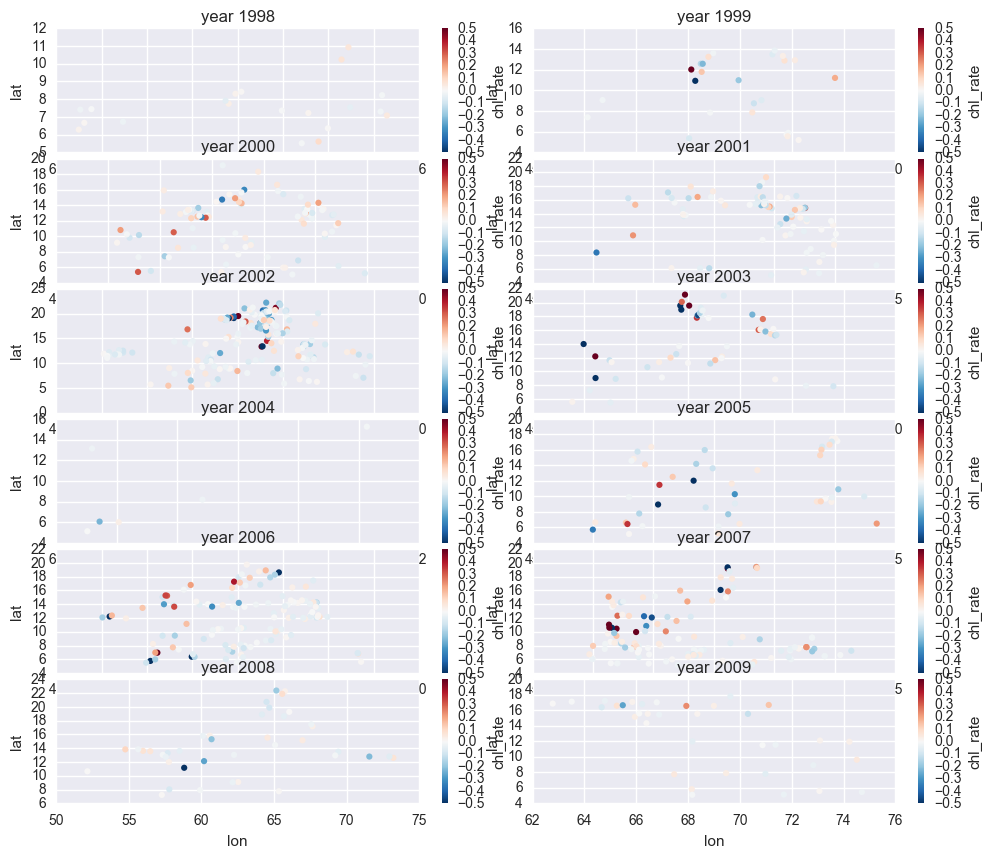

In [64]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(1998,2010), axes.flat) :
    tmpyear = floatsDFAllRate_8Dtimeorder[ (floatsDFAllRate_8Dtimeorder.time > str(i))  & (floatsDFAllRate_8Dtimeorder.time < str(i+1)) ] # if year i
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.5, vmax=0.5, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)

(18,)
(16,)
(75,)
(58,)
(56,)
(1,)
(5,)
(84,)
(52,)
(42,)
(34,)
(48,)


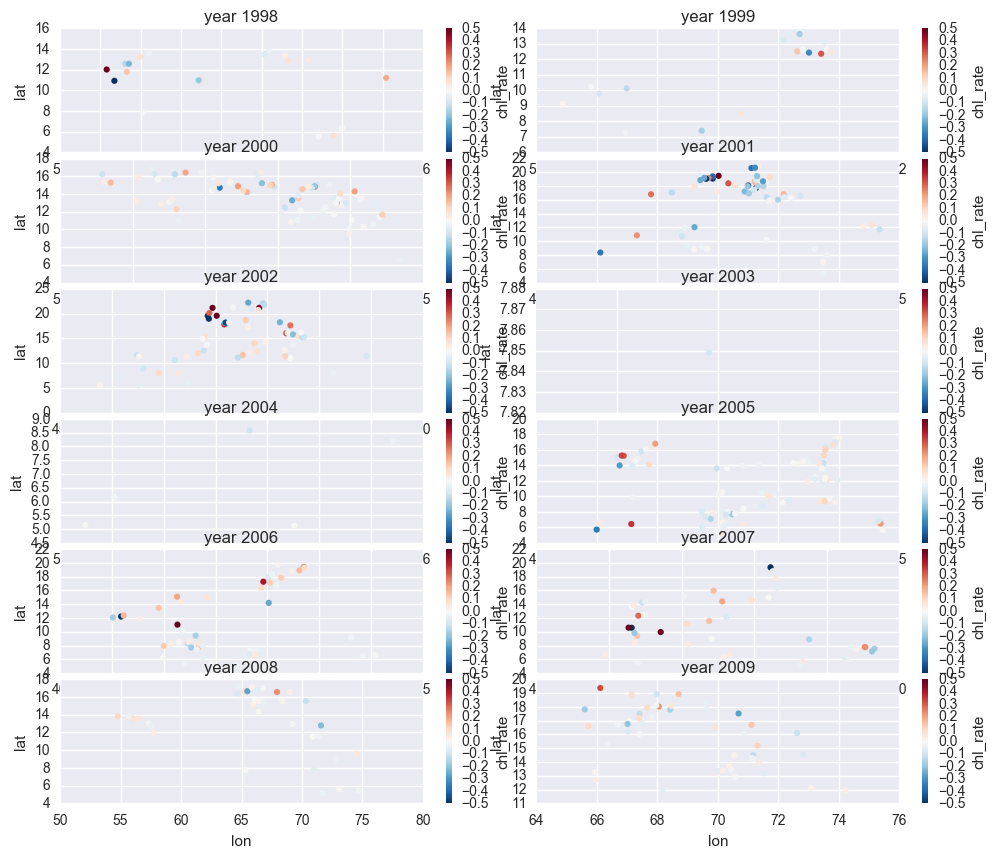

In [65]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(1998,2010), axes.flat) :
    tmpyear = floatsDFAllRate_8Dtimeorder[ (floatsDFAllRate_8Dtimeorder.time > (str(i)+ '-11-01') )  & (floatsDFAllRate_8Dtimeorder.time < (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.5, vmax=0.5, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)

# since there are negative values in the chl_rate, so do not take log_10, we will get more data points  # total is 489

In [ ]:
# let's output the data as a csv or hdf file to disk to save the experiment time

df_list = []
for i, ax in zip(range(1998,2010), axes.flat) :
    tmpyear = floatsDFAllRate_8Dtimeorder[ (floatsDFAllRate_8Dtimeorder.time > (str(i)+ '-11-01') )  & (floatsDFAllRate_8Dtimeorder.time < (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
df_chl_out_8D = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_8D.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
df_chl_out_8D.to_hdf('df_chl_out_8D.h5','df_chl_out_8D')